# Notebook to generate plots of example datasets and MEDiCINe results

Be sure to have either downloaded or generated the datasets and the motion
estimation results before running this notebook. See
`../simulated_data/motion_estimation` for details.

In [1]:
"""Imports."""

from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate as scipy_interpolate

import sys
sys.path.append('../simulated_data/motion_estimation')
import utils as motion_estimation_utils
import run_compute_errors

In [2]:
"""Parameters."""

SAMPLING_FREQUENCY = 32000

dataset_params = [
    dict(
        drift_rate=0.,
        random_walk_sigma=2.,
        random_jump_rate=0.0,
        unit_num=20,
        homogeneity="uniform",
        stability="ramps",
        non_rigidity=0.,
    ),
    dict(
        drift_rate=0.,
        random_walk_sigma=0.,
        random_jump_rate=0.01,
        unit_num=100,
        homogeneity="bimodal",
        stability="asynchronous_periodic",
        non_rigidity=0.,
    ),
    dict(
        drift_rate=0.1,
        random_walk_sigma=2.,
        random_jump_rate=0.01,
        unit_num=20,
        homogeneity="bimodal",
        stability="stable",
        non_rigidity=0.5,
    ),
]

In [3]:
"""Helper functions."""

def _params_to_string(params):
    params_string = ''
    for key, value in params.items():
        k = key[0]
        if k == 'r':
            k = k + key.split('_')[1][0]
        if '_' in str(value):
            value = value.split('_')[0]
        params_string += f'{k}={value}_'
    return params_string[:-1]


def get_true_drift(recording_dir, min_eval_depth=-500, max_eval_depth=500, n_depth_levels=10):
    """Load true drift vector."""

    # Load drift times and values
    drift_dict = np.load(
        recording_dir / 'drift_dict.npy', allow_pickle=True).item()
    eval_times = drift_dict['external_drift_times']
    eval_depths = np.linspace(min_eval_depth, max_eval_depth, n_depth_levels)
    true_drift = drift_dict['external_drift_vector_um']
    external_drift_factors = drift_dict['external_drift_factors']

    # Remove first and last 50 values to ensure interpolation is valid
    eval_times = eval_times[50:-50]
    true_drift = true_drift[50:-50]

    # Load unit depths
    unit_depths = np.load(recording_dir / 'unit_depths.npy')
    
    true_drift = run_compute_errors.compute_true_drift_values(
        eval_depths=eval_depths,
        true_drift=true_drift,
        unit_depths=unit_depths,
        external_drift_factors=external_drift_factors,
    )

    return true_drift, eval_times, eval_depths


def get_medicine_correction(recording_dir):
    medicine_dir = motion_estimation_utils.MOTION_ESTIMATION_DIR / recording_dir.name / 'medicine'
    depth_bins = np.load(medicine_dir / 'depth_bins.npy')
    time_bins = np.load(medicine_dir / 'time_bins.npy')
    motion = np.load(medicine_dir / 'motion.npy')
    return depth_bins, time_bins, motion


def correct_motion_on_peaks(peak_times,
                            peak_depths,
                            motion,
                            time_bins,
                            depth_bins):
    corrected_peak_depths = peak_depths.copy()
    f = scipy_interpolate.RegularGridInterpolator(
        (time_bins, depth_bins),
        motion,
        method='linear',
        bounds_error=False,
        fill_value=None,
    )
    shift = f(np.c_[peak_times, peak_depths])
    corrected_peak_depths -= shift

    return corrected_peak_depths


def load_data(recording_dir, stride=30):
    # Load peak depths, times, and amplitudes
    peak_locations = np.load(recording_dir / 'peak_locations.npy')
    peak_locations = np.array([x.tolist() for x in peak_locations])
    peak_locations = dict(
        x=peak_locations[:, 0],
        y=peak_locations[:, 1],
        z=peak_locations[:, 2],
        alpha=peak_locations[:, 3],
    )
    peak_depths = peak_locations['y']
    peaks = np.load(recording_dir / 'peaks.npy')
    peaks = np.array([x.tolist() for x in peaks])
    peaks = dict(
        sample_index=peaks[:, 0],
        channel_index=peaks[:, 1],
        amplitude=peaks[:, 2],
        segment_index=peaks[:, 3],
    )
    peak_amplitudes = peaks['amplitude']
    peak_times = peaks['sample_index'] / SAMPLING_FREQUENCY

    # Stride to reduce number of points plotted
    peak_times_plot = peak_times[::stride]
    peak_depths_plot = peak_depths[::stride]
    peak_amplitudes_plot = -1 * peak_amplitudes[::stride]
    
    return peak_times_plot, peak_depths_plot, peak_amplitudes_plot

/Users/nicholaswatters/Desktop/grad_school/research/mehrdad/medicine_paper/simulated_data/motion_estimation/../../cache/simulated_datasets/0161
/Users/nicholaswatters/Desktop/grad_school/research/mehrdad/medicine_paper/simulated_data/motion_estimation/../../cache/simulated_datasets/0104
/Users/nicholaswatters/Desktop/grad_school/research/mehrdad/medicine_paper/simulated_data/motion_estimation/../../cache/simulated_datasets/0283
/Users/nicholaswatters/Desktop/grad_school/research/mehrdad/medicine_paper/simulated_data/motion_estimation/../../cache/simulated_datasets/0161
/Users/nicholaswatters/Desktop/grad_school/research/mehrdad/medicine_paper/simulated_data/motion_estimation/../../cache/simulated_datasets/0104
/Users/nicholaswatters/Desktop/grad_school/research/mehrdad/medicine_paper/simulated_data/motion_estimation/../../cache/simulated_datasets/0283


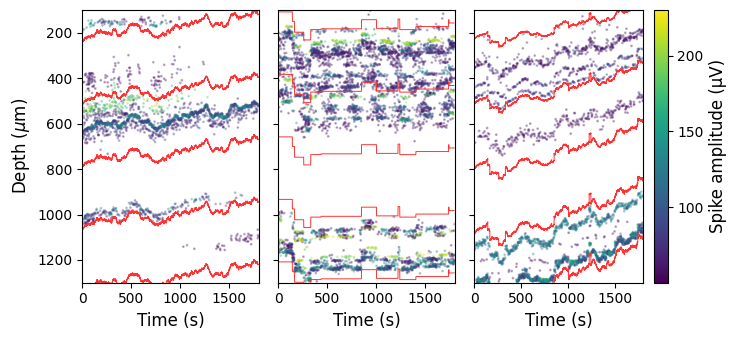

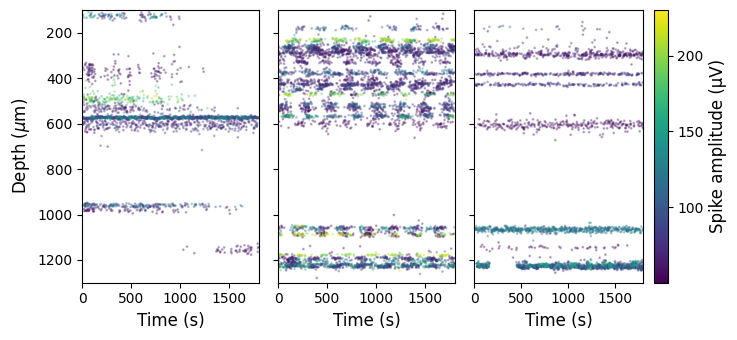

In [23]:
"""Plot spikes and motion for dataset."""

for label in ['raw', 'corrected']:
    fig, axes = plt.subplots(
        1, 3, figsize=(7.5, 3.5), sharey=True, sharex=True,
        gridspec_kw={'width_ratios': (1, 1, 1.2)})
    for i in range(3):
        params = dataset_params[i]
        params_string = _params_to_string(params)
        recording_dir = motion_estimation_utils.get_recording_dirs(**params)[0]
        print(recording_dir)
        ax = axes[i]

        peak_times, peak_depths, peak_amplitudes = load_data(recording_dir, stride=30)
        true_drift, eval_times, eval_depths = get_true_drift(
            recording_dir, min_eval_depth=-470, max_eval_depth=630, n_depth_levels=5)

        peak_amplitudes[peak_amplitudes > 230] = 230

        # Truncate to only keep desired peaks
        ylim = (-500, 700)
        keep_indices = (peak_depths > ylim[0]) * (peak_depths < ylim[1])
        peak_times = peak_times[keep_indices]
        peak_depths = peak_depths[keep_indices]
        peak_amplitudes = peak_amplitudes[keep_indices]

        # Get corrected peaks if necessary
        if label == 'corrected':
            depth_bins, time_bins, motion = get_medicine_correction(recording_dir)
            peak_depths = correct_motion_on_peaks(
                peak_times, peak_depths, motion, time_bins, depth_bins)

        # Make scatterplot
        min_peak_amp = min(peak_amplitudes)
        max_peak_amp = max(peak_amplitudes)
        ax.scatter(
            peak_times, peak_depths, s=1, c=peak_amplitudes,
            alpha=0.3, cmap='viridis', vmin=min_peak_amp, vmax=max_peak_amp)
        
        ax.set_xlabel('Time (s)', fontsize=12)
        ax.set_xlim(0, 1800)
        yticks = ax.get_yticks()
        yticks = [int(ytick) for ytick in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels([800 - x for x in yticks], fontsize=10)
        ax.set_ylim(ylim)
        if i == 0:
            ax.set_ylabel('Depth ($\mu$m)', fontsize=12)

        # Add amplitude colorbar with same scale as raster without washed out colors
        if i == 2:
            cbar = plt.colorbar(ax.collections[0], ax=ax)
            cbar.solids.set(alpha=1)
            cbar.set_label('Spike amplitude (µV)', fontsize=12)
            cbar.set_ticks(np.arange(50 * np.ceil(min_peak_amp / 50), max_peak_amp, 50))

        # Plot true motion if necessary
        if label == 'raw':
            for i, depth in enumerate(eval_depths):
                ax.plot(eval_times, depth + true_drift[:, i], c=(1.0, 0.2, 0.2), linewidth=0.7)
    
    fig.tight_layout()